## ESO FORECASTING NOTEBOOK

In [226]:
## ESO Notebook
#This is my notebook for this comptition. Previous to this I have done a fair amount of pre-processing to the ESO data.
# Here I will only do the ML element of the comptetition.

In [227]:
# Import necessary libraries

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from matplotlib import rcParams  # Used to set default paremeters
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler



In [228]:
## Plotting parameters for the whole project
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [229]:
# Load your dataset
# Assuming your dataset is in a CSV file with columns: timestamp, feature1, feature2, ..., target
train = pd.read_csv("Train_XGB.csv",  parse_dates=['UTC_Settlement_DateTime'], index_col='UTC_Settlement_DateTime')
test = pd.read_csv("Test_XGB.csv", parse_dates=['UTC_Settlement_DateTime'], index_col='UTC_Settlement_DateTime')

In [230]:
train

,Target,East_Midlands_price,Eastern_England_price,London_price,Merseyside_and_Northern_Wales_price,North_Western_England_price,Northern_Scotland_price,South_Western_England_price,Southern_England_price,Southern_Scotland_price,...,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
UTC_Settlement_DateTime,,,,,,,,,,,,,,,,,,,,,
2020-08-10 23:30:00,1.528,5.985,6.279,5.985,6.5835,6.279,7.1820,6.8880,6.279,6.279,...,10,0,223,3,8,2020,33,0.000,0.000,0.000
2020-08-11 00:00:00,0.178,6.300,6.615,6.300,6.9300,6.615,7.5600,7.2450,6.615,6.615,...,11,1,224,3,8,2020,33,0.000,0.000,0.000
2020-08-11 00:30:00,-1.242,6.300,6.615,6.300,6.9300,6.615,7.5600,7.2450,6.615,6.615,...,11,1,224,3,8,2020,33,0.000,0.000,0.000
2020-08-11 01:00:00,2.104,5.985,6.279,5.985,6.5835,6.279,7.1820,6.8880,6.279,6.279,...,11,1,224,3,8,2020,33,0.000,0.000,0.000
2020-08-11 01:30:00,-0.664,5.985,6.279,5.985,6.5835,6.279,7.1820,6.8880,6.279,6.279,...,11,1,224,3,8,2020,33,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-10 21:30:00,1.646,21.000,22.050,21.000,23.1000,22.050,25.2000,24.1500,22.050,22.050,...,10,3,314,4,11,2022,45,0.724,-0.400,-1.712
2022-11-10 22:00:00,-0.188,20.160,21.168,20.160,22.1760,21.168,24.1920,23.1840,21.168,21.168,...,10,3,314,4,11,2022,45,-2.304,-0.786,-1.844
2022-11-10 22:30:00,0.178,15.540,16.317,15.540,17.0940,16.317,18.6480,17.8710,16.317,16.317,...,10,3,314,4,11,2022,45,0.956,0.426,-0.768


In [231]:
test

,East_Midlands_price,Eastern_England_price,London_price,Merseyside_and_Northern_Wales_price,North_Western_England_price,Northern_Scotland_price,South_Western_England_price,Southern_England_price,Southern_Scotland_price,West_Midlands_price,...,generationtime_msSouthhampton - Portsmouth_weather,utc_offset_secondsSouthhampton - Portsmouth_weather,elevationSouthhampton - Portsmouth_weather,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year
UTC_Settlement_DateTime,,,,,,,,,,,,,,,,,,,,,
2022-01-12 00:00:00,35.071785,37.717785,35.797230,40.363785,37.717785,45.655785,43.009785,37.717785,37.717785,37.717785,...,61.430931,0.0,10.0,12,2,12,1,1,2022,2
2022-01-12 00:30:00,38.851785,41.686785,38.851785,44.521785,41.686785,50.191785,47.356785,41.686785,41.686785,41.686785,...,61.430931,0.0,10.0,12,2,12,1,1,2022,2
2022-01-12 01:00:00,35.533785,38.200785,35.797230,40.867785,38.200785,46.212285,43.545285,38.200785,38.200785,38.200785,...,61.430931,0.0,10.0,12,2,12,1,1,2022,2
2022-01-12 01:30:00,33.874785,36.457785,35.797230,39.051285,36.457785,44.217285,41.634285,36.457785,36.457785,36.457785,...,61.430931,0.0,10.0,12,2,12,1,1,2022,2
2022-01-12 02:00:00,33.018090,35.056875,35.797230,36.940785,34.452285,41.928285,39.439785,34.452285,34.452285,34.452285,...,61.430931,0.0,10.0,12,2,12,1,1,2022,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05 21:30:00,17.010000,17.860500,17.010000,18.711000,17.860500,20.412000,19.561500,17.860500,17.860500,17.860500,...,61.430931,0.0,10.0,5,1,339,4,12,2023,49
2023-12-05 22:00:00,19.918500,20.916000,19.918500,21.913500,20.916000,23.898000,22.911000,20.916000,20.916000,20.916000,...,61.430931,0.0,10.0,5,1,339,4,12,2023,49
2023-12-05 22:30:00,17.892000,18.784500,17.892000,19.677000,18.784500,21.472500,20.580000,18.784500,18.784500,18.784500,...,61.430931,0.0,10.0,5,1,339,4,12,2023,49


In [232]:

# Create features and target variables
X_train = train.drop(columns=['Target']) 
y_train = train['Target']

# Dimensionality reduction: feature importance

I am going to use XGBOOST to find which are the more imporant featuresand will use the new reduced dataset with less variable but keeping most of the info

In [233]:
params = {'objective': 'reg:squarederror'}
dtrain = xgb.DMatrix(X_train, label=y_train)
model = xgb.train(params, dtrain)
importance = model.get_score(importance_type='weight')
important_features = list(importance.keys())

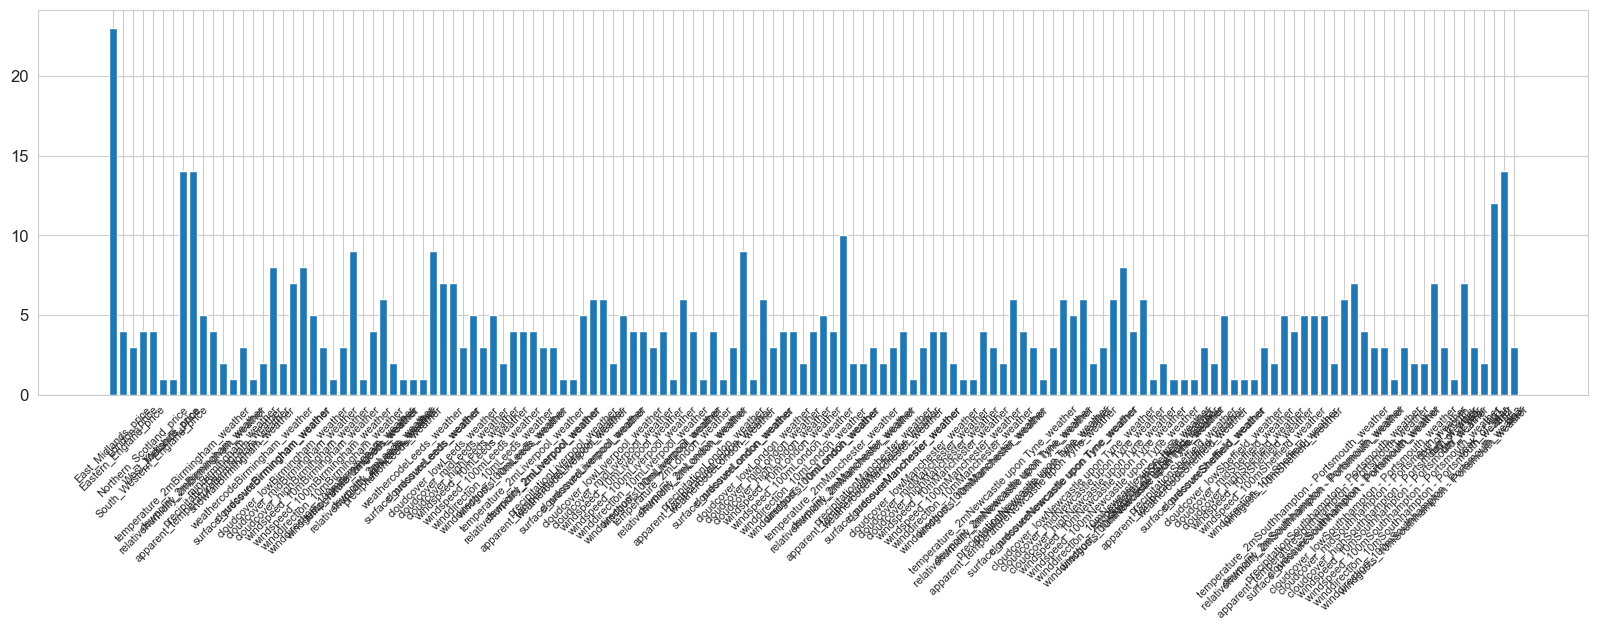

In [234]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.bar(range(len(importance)), list(importance.values()), tick_label=list(importance.keys()))
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [235]:
importance_df = pd.DataFrame(list(importance.items()), columns=['feature', 'importance'])

In [236]:
most_important_variables = importance_df.loc[importance_df['importance'] > 3]

In [237]:
most_important_variables

,feature,importance
0,East_Midlands_price,23.0
1,Eastern_England_price,4.0
3,Northern_Scotland_price,4.0
4,South_Western_England_price,4.0
7,temperature_2mBirmingham_weather,14.0
...,...,...
125,cloudcover_lowSouthhampton - Portsmouth_weather,4.0
132,windgusts_10mSouthhampton - Portsmouth_weather,7.0
135,day_of_year,7.0
138,lag1,12.0


In [238]:
important_features_list = most_important_variables['feature'].to_list()

In [239]:
X_train = X_train[important_features_list]

In [240]:
X_train

,East_Midlands_price,Eastern_England_price,Northern_Scotland_price,South_Western_England_price,temperature_2mBirmingham_weather,relativehumidity_2mBirmingham_weather,dewpoint_2mBirmingham_weather,apparent_temperatureBirmingham_weather,cloudcoverBirmingham_weather,cloudcover_midBirmingham_weather,...,relativehumidity_2mSouthhampton - Portsmouth_weather,dewpoint_2mSouthhampton - Portsmouth_weather,apparent_temperatureSouthhampton - Portsmouth_weather,surface_pressureSouthhampton - Portsmouth_weather,cloudcoverSouthhampton - Portsmouth_weather,cloudcover_lowSouthhampton - Portsmouth_weather,windgusts_10mSouthhampton - Portsmouth_weather,day_of_year,lag1,lag2
UTC_Settlement_DateTime,,,,,,,,,,,,,,,,,,,,,
2020-08-10 23:30:00,5.985,6.279,7.1820,6.8880,10.2,93.0,7.7,5.2,100.0,0.0,...,88.0,8.1,8.2,1017.2,100.0,0.0,31.7,223,0.000,0.000
2020-08-11 00:00:00,6.300,6.615,7.5600,7.2450,20.4,85.0,17.7,21.5,53.0,60.0,...,92.0,17.7,21.3,1013.4,83.0,83.0,6.8,224,0.000,0.000
2020-08-11 00:30:00,6.300,6.615,7.5600,7.2450,10.2,93.0,7.7,5.2,100.0,0.0,...,88.0,8.1,8.2,1017.2,100.0,0.0,31.7,224,0.000,0.000
2020-08-11 01:00:00,5.985,6.279,7.1820,6.8880,19.9,87.0,17.6,21.1,57.0,78.0,...,94.0,17.6,21.1,1013.4,87.0,92.0,4.7,224,0.000,0.000
2020-08-11 01:30:00,5.985,6.279,7.1820,6.8880,10.2,93.0,7.7,5.2,100.0,0.0,...,88.0,8.1,8.2,1017.2,100.0,0.0,31.7,224,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-10 21:30:00,21.000,22.050,25.2000,24.1500,10.2,93.0,7.7,5.2,100.0,0.0,...,88.0,8.1,8.2,1017.2,100.0,0.0,31.7,314,0.724,-0.400
2022-11-10 22:00:00,20.160,21.168,24.1920,23.1840,13.1,83.0,10.3,8.8,100.0,0.0,...,84.0,12.5,12.1,1023.0,100.0,95.0,45.7,314,-2.304,-0.786
2022-11-10 22:30:00,15.540,16.317,18.6480,17.8710,10.2,93.0,7.7,5.2,100.0,0.0,...,88.0,8.1,8.2,1017.2,100.0,0.0,31.7,314,0.956,0.426


In [241]:
y_train

UTC_Settlement_DateTime
2020-08-10 23:30:00    1.528
2020-08-11 00:00:00    0.178
2020-08-11 00:30:00   -1.242
2020-08-11 01:00:00    2.104
2020-08-11 01:30:00   -0.664
                       ...  
2022-11-10 21:30:00    1.646
2022-11-10 22:00:00   -0.188
2022-11-10 22:30:00    0.178
2022-11-10 23:00:00   -1.498
2022-11-10 23:30:00   -3.086
Name: Target, Length: 39326, dtype: float64

Now we have both datasets ready to feed the model but what I am going to to do is split the training following what Rob Mulla has done and then work on it.

In [242]:
df = pd.concat([X_train,y_train], axis= 1)

In [243]:
df

,East_Midlands_price,Eastern_England_price,Northern_Scotland_price,South_Western_England_price,temperature_2mBirmingham_weather,relativehumidity_2mBirmingham_weather,dewpoint_2mBirmingham_weather,apparent_temperatureBirmingham_weather,cloudcoverBirmingham_weather,cloudcover_midBirmingham_weather,...,dewpoint_2mSouthhampton - Portsmouth_weather,apparent_temperatureSouthhampton - Portsmouth_weather,surface_pressureSouthhampton - Portsmouth_weather,cloudcoverSouthhampton - Portsmouth_weather,cloudcover_lowSouthhampton - Portsmouth_weather,windgusts_10mSouthhampton - Portsmouth_weather,day_of_year,lag1,lag2,Target
UTC_Settlement_DateTime,,,,,,,,,,,,,,,,,,,,,
2020-08-10 23:30:00,5.985,6.279,7.1820,6.8880,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,223,0.000,0.000,1.528
2020-08-11 00:00:00,6.300,6.615,7.5600,7.2450,20.4,85.0,17.7,21.5,53.0,60.0,...,17.7,21.3,1013.4,83.0,83.0,6.8,224,0.000,0.000,0.178
2020-08-11 00:30:00,6.300,6.615,7.5600,7.2450,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,224,0.000,0.000,-1.242
2020-08-11 01:00:00,5.985,6.279,7.1820,6.8880,19.9,87.0,17.6,21.1,57.0,78.0,...,17.6,21.1,1013.4,87.0,92.0,4.7,224,0.000,0.000,2.104
2020-08-11 01:30:00,5.985,6.279,7.1820,6.8880,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,224,0.000,0.000,-0.664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-10 21:30:00,21.000,22.050,25.2000,24.1500,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,314,0.724,-0.400,1.646
2022-11-10 22:00:00,20.160,21.168,24.1920,23.1840,13.1,83.0,10.3,8.8,100.0,0.0,...,12.5,12.1,1023.0,100.0,95.0,45.7,314,-2.304,-0.786,-0.188
2022-11-10 22:30:00,15.540,16.317,18.6480,17.8710,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,314,0.956,0.426,0.178


# Cross validaton

In [244]:
threshold_date_1 = "10-6-2022"
threshold_date_2 = "10-10-2022"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

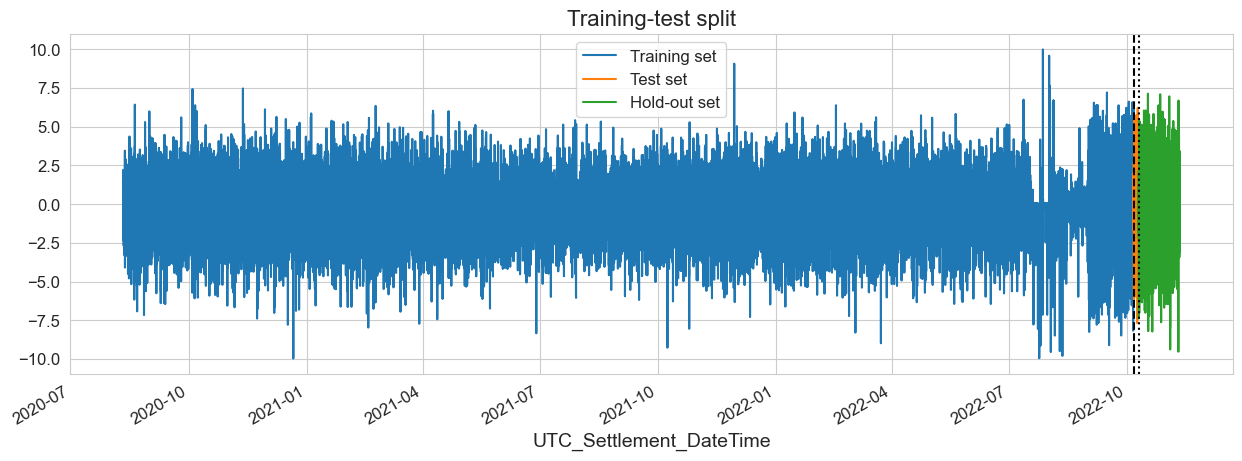

In [245]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["Target"].plot(ax=ax, label="Training set")
test_data["Target"].plot(ax=ax, label="Test set")
hold_out_data["Target"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

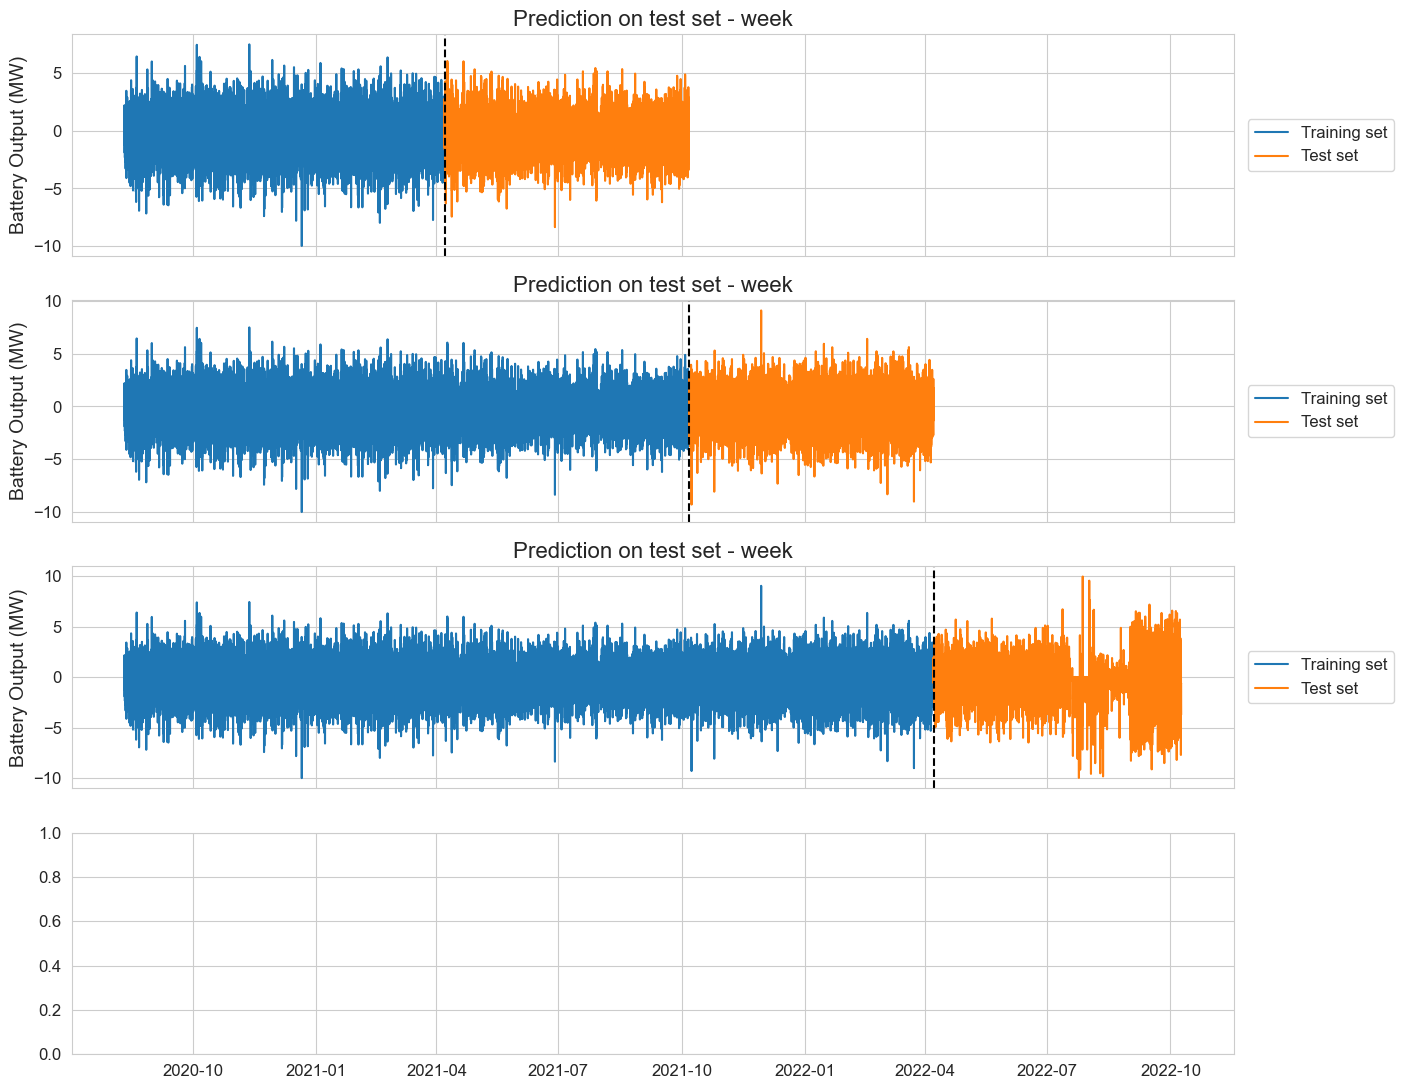

In [246]:
threshold_date_1 = "10-09-2022"
n_years_test = 1

tss = TimeSeriesSplit(n_splits=3, test_size=24 * 365 * n_years_test, gap=24)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["Target"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test['Target'].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Battery Output (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [247]:
# Create features and target variables
X_train = df.drop(columns=['Target']) 
y_train = df['Target']

X_hold_out = hold_out_data.drop(columns=['Target']) 
y_hold_out = hold_out_data['Target']

# Define fit parameters to allow early stopping in GridSearchCV
fit_params = {
    "early_stopping_rounds": 50,
    "eval_metric": "rmse",
    "eval_set": [[X_hold_out, y_hold_out]],
    
}

# Define estimator
estimator = xgb.XGBRegressor(
    base_score=0.5, 
    booster="gbtree",  
    learning_rate=0.01,
    tree_method="gpu_hist",
    random_state=43, 
)

# Define parameters to optimiser
param_search = {
    "max_depth": [3, 5], 
    "n_estimators": [350, 500, 650], 
    "subsample": [0.95, 0.8, 0.7],
}


# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

xgb_search.fit(X_train, y_train, verbose=500, **fit_params);

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[0]	validation_0-rmse:2.55759


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

[285]	validation_0-rmse:2.46326
[CV 1/3] END max_depth=3, n_estimators=350, subsample=0.95;, score=-1.519 total time=   1.2s


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:2.55787


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

[349]	validation_0-rmse:2.46351
[CV 2/3] END max_depth=3, n_estimators=350, subsample=0.95;, score=-1.754 total time=   1.3s
[0]	validation_0-rmse:2.55796


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[349]	validation_0-rmse:2.46524
[CV 3/3] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2.003 total time=   1.1s
[0]	validation_0-rmse:2.55748


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[275]	validation_0-rmse:2.46292
[CV 1/3] END max_depth=3, n_estimators=350, subsample=0.8;, score=-1.519 total time=   0.8s
[0]	validation_0-rmse:2.55788


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[349]	validation_0-rmse:2.46263
[CV 2/3] END max_depth=3, n_estimators=350, subsample=0.8;, score=-1.754 total time=   1.2s
[0]	validation_0-rmse:2.55787


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[349]	validation_0-rmse:2.46499
[CV 3/3] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2.003 total time=   1.3s
[0]	validation_0-rmse:2.55766


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[242]	validation_0-rmse:2.46318
[CV 1/3] END max_depth=3, n_estimators=350, subsample=0.7;, score=-1.517 total time=   0.7s
[0]	validation_0-rmse:2.55788


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[349]	validation_0-rmse:2.46315
[CV 2/3] END max_depth=3, n_estimators=350, subsample=0.7;, score=-1.754 total time=   1.1s
[0]	validation_0-rmse:2.55784


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[349]	validation_0-rmse:2.46469
[CV 3/3] END max_depth=3, n_estimators=350, subsample=0.7;, score=-2.003 total time=   1.1s
[0]	validation_0-rmse:2.55759


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[284]	validation_0-rmse:2.46327
[CV 1/3] END max_depth=3, n_estimators=500, subsample=0.95;, score=-1.519 total time=   0.8s
[0]	validation_0-rmse:2.55787


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[358]	validation_0-rmse:2.46352
[CV 2/3] END max_depth=3, n_estimators=500, subsample=0.95;, score=-1.754 total time=   1.1s
[0]	validation_0-rmse:2.55796


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[421]	validation_0-rmse:2.46538
[CV 3/3] END max_depth=3, n_estimators=500, subsample=0.95;, score=-2.003 total time=   1.4s
[0]	validation_0-rmse:2.55748


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[274]	validation_0-rmse:2.46291
[CV 1/3] END max_depth=3, n_estimators=500, subsample=0.8;, score=-1.519 total time=   0.9s
[0]	validation_0-rmse:2.55788


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[496]	validation_0-rmse:2.46257
[CV 2/3] END max_depth=3, n_estimators=500, subsample=0.8;, score=-1.755 total time=   1.5s
[0]	validation_0-rmse:2.55787


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[384]	validation_0-rmse:2.46510
[CV 3/3] END max_depth=3, n_estimators=500, subsample=0.8;, score=-2.003 total time=   1.2s
[0]	validation_0-rmse:2.55766


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[243]	validation_0-rmse:2.46318
[CV 1/3] END max_depth=3, n_estimators=500, subsample=0.7;, score=-1.517 total time=   0.7s
[0]	validation_0-rmse:2.55788


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[350]	validation_0-rmse:2.46318
[CV 2/3] END max_depth=3, n_estimators=500, subsample=0.7;, score=-1.754 total time=   1.0s
[0]	validation_0-rmse:2.55784


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[430]	validation_0-rmse:2.46491
[CV 3/3] END max_depth=3, n_estimators=500, subsample=0.7;, score=-2.003 total time=   1.4s
[0]	validation_0-rmse:2.55759


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[285]	validation_0-rmse:2.46326
[CV 1/3] END max_depth=3, n_estimators=650, subsample=0.95;, score=-1.519 total time=   0.8s
[0]	validation_0-rmse:2.55787


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[358]	validation_0-rmse:2.46352
[CV 2/3] END max_depth=3, n_estimators=650, subsample=0.95;, score=-1.754 total time=   1.1s
[0]	validation_0-rmse:2.55796


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[421]	validation_0-rmse:2.46538
[CV 3/3] END max_depth=3, n_estimators=650, subsample=0.95;, score=-2.003 total time=   1.3s
[0]	validation_0-rmse:2.55748


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[275]	validation_0-rmse:2.46292
[CV 1/3] END max_depth=3, n_estimators=650, subsample=0.8;, score=-1.519 total time=   0.8s
[0]	validation_0-rmse:2.55788


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[496]	validation_0-rmse:2.46257
[CV 2/3] END max_depth=3, n_estimators=650, subsample=0.8;, score=-1.755 total time=   1.5s
[0]	validation_0-rmse:2.55787


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[385]	validation_0-rmse:2.46513
[CV 3/3] END max_depth=3, n_estimators=650, subsample=0.8;, score=-2.003 total time=   1.2s
[0]	validation_0-rmse:2.55766


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[242]	validation_0-rmse:2.46318
[CV 1/3] END max_depth=3, n_estimators=650, subsample=0.7;, score=-1.517 total time=   0.7s
[0]	validation_0-rmse:2.55788


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[350]	validation_0-rmse:2.46318
[CV 2/3] END max_depth=3, n_estimators=650, subsample=0.7;, score=-1.754 total time=   1.1s
[0]	validation_0-rmse:2.55784


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[431]	validation_0-rmse:2.46492
[CV 3/3] END max_depth=3, n_estimators=650, subsample=0.7;, score=-2.003 total time=   1.4s
[0]	validation_0-rmse:2.55776


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[231]	validation_0-rmse:2.46442
[CV 1/3] END max_depth=5, n_estimators=350, subsample=0.95;, score=-1.519 total time=   0.9s
[0]	validation_0-rmse:2.55785


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[349]	validation_0-rmse:2.46451
[CV 2/3] END max_depth=5, n_estimators=350, subsample=0.95;, score=-1.759 total time=   1.3s
[0]	validation_0-rmse:2.55791


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[349]	validation_0-rmse:2.46569
[CV 3/3] END max_depth=5, n_estimators=350, subsample=0.95;, score=-2.004 total time=   1.3s
[0]	validation_0-rmse:2.55751


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[294]	validation_0-rmse:2.46174
[CV 1/3] END max_depth=5, n_estimators=350, subsample=0.8;, score=-1.520 total time=   1.1s
[0]	validation_0-rmse:2.55790


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[289]	validation_0-rmse:2.46405
[CV 2/3] END max_depth=5, n_estimators=350, subsample=0.8;, score=-1.755 total time=   1.1s
[0]	validation_0-rmse:2.55795


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[349]	validation_0-rmse:2.46616
[CV 3/3] END max_depth=5, n_estimators=350, subsample=0.8;, score=-2.003 total time=   1.3s
[0]	validation_0-rmse:2.55760


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[238]	validation_0-rmse:2.46274
[CV 1/3] END max_depth=5, n_estimators=350, subsample=0.7;, score=-1.518 total time=   0.8s
[0]	validation_0-rmse:2.55788


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[349]	validation_0-rmse:2.46433
[CV 2/3] END max_depth=5, n_estimators=350, subsample=0.7;, score=-1.757 total time=   1.2s
[0]	validation_0-rmse:2.55786


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[349]	validation_0-rmse:2.46603
[CV 3/3] END max_depth=5, n_estimators=350, subsample=0.7;, score=-2.003 total time=   1.3s
[0]	validation_0-rmse:2.55776


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[231]	validation_0-rmse:2.46442
[CV 1/3] END max_depth=5, n_estimators=500, subsample=0.95;, score=-1.519 total time=   0.8s
[0]	validation_0-rmse:2.55785


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[393]	validation_0-rmse:2.46472
[CV 2/3] END max_depth=5, n_estimators=500, subsample=0.95;, score=-1.759 total time=   1.5s
[0]	validation_0-rmse:2.55791


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[390]	validation_0-rmse:2.46611
[CV 3/3] END max_depth=5, n_estimators=500, subsample=0.95;, score=-2.004 total time=   1.5s
[0]	validation_0-rmse:2.55751


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[294]	validation_0-rmse:2.46174
[CV 1/3] END max_depth=5, n_estimators=500, subsample=0.8;, score=-1.520 total time=   1.0s
[0]	validation_0-rmse:2.55790


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[289]	validation_0-rmse:2.46405
[CV 2/3] END max_depth=5, n_estimators=500, subsample=0.8;, score=-1.755 total time=   1.1s
[0]	validation_0-rmse:2.55795


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[412]	validation_0-rmse:2.46656
[CV 3/3] END max_depth=5, n_estimators=500, subsample=0.8;, score=-2.003 total time=   1.5s
[0]	validation_0-rmse:2.55760


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[238]	validation_0-rmse:2.46274
[CV 1/3] END max_depth=5, n_estimators=500, subsample=0.7;, score=-1.518 total time=   0.9s
[0]	validation_0-rmse:2.55788


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[351]	validation_0-rmse:2.46426
[CV 2/3] END max_depth=5, n_estimators=500, subsample=0.7;, score=-1.757 total time=   1.3s
[0]	validation_0-rmse:2.55786


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[363]	validation_0-rmse:2.46604
[CV 3/3] END max_depth=5, n_estimators=500, subsample=0.7;, score=-2.003 total time=   1.5s
[0]	validation_0-rmse:2.55776


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[231]	validation_0-rmse:2.46442
[CV 1/3] END max_depth=5, n_estimators=650, subsample=0.95;, score=-1.519 total time=   0.8s
[0]	validation_0-rmse:2.55785


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[394]	validation_0-rmse:2.46474
[CV 2/3] END max_depth=5, n_estimators=650, subsample=0.95;, score=-1.759 total time=   1.4s
[0]	validation_0-rmse:2.55791


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[391]	validation_0-rmse:2.46611
[CV 3/3] END max_depth=5, n_estimators=650, subsample=0.95;, score=-2.004 total time=   1.4s
[0]	validation_0-rmse:2.55751


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[294]	validation_0-rmse:2.46174
[CV 1/3] END max_depth=5, n_estimators=650, subsample=0.8;, score=-1.520 total time=   1.0s
[0]	validation_0-rmse:2.55790


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[289]	validation_0-rmse:2.46405
[CV 2/3] END max_depth=5, n_estimators=650, subsample=0.8;, score=-1.755 total time=   1.1s
[0]	validation_0-rmse:2.55795


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[412]	validation_0-rmse:2.46656
[CV 3/3] END max_depth=5, n_estimators=650, subsample=0.8;, score=-2.003 total time=   1.5s
[0]	validation_0-rmse:2.55760


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[238]	validation_0-rmse:2.46274
[CV 1/3] END max_depth=5, n_estimators=650, subsample=0.7;, score=-1.518 total time=   0.8s
[0]	validation_0-rmse:2.55788


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[352]	validation_0-rmse:2.46431
[CV 2/3] END max_depth=5, n_estimators=650, subsample=0.7;, score=-1.757 total time=   1.6s


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:2.55786


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

[363]	validation_0-rmse:2.46604
[CV 3/3] END max_depth=5, n_estimators=650, subsample=0.7;, score=-2.003 total time=   1.6s
[0]	validation_0-rmse:2.55764


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

[499]	validation_0-rmse:2.44334


In [248]:
xgb_search.best_params_

{'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}

# Predicction into the future

In [253]:

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1)
best =xgb_best.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train)],
    verbose=100,
    early_stopping_rounds=50,
);

[0]	validation_0-rmse:1.89479


c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ivan.sanz\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.78928
[200]	validation_0-rmse:1.77144
[300]	validation_0-rmse:1.76591
[400]	validation_0-rmse:1.76248
[499]	validation_0-rmse:1.75954


In [250]:
test

,East_Midlands_price,Eastern_England_price,Northern_Scotland_price,South_Western_England_price,temperature_2mBirmingham_weather,relativehumidity_2mBirmingham_weather,dewpoint_2mBirmingham_weather,apparent_temperatureBirmingham_weather,cloudcoverBirmingham_weather,cloudcover_midBirmingham_weather,...,dewpoint_2mSouthhampton - Portsmouth_weather,apparent_temperatureSouthhampton - Portsmouth_weather,surface_pressureSouthhampton - Portsmouth_weather,cloudcoverSouthhampton - Portsmouth_weather,cloudcover_lowSouthhampton - Portsmouth_weather,windgusts_10mSouthhampton - Portsmouth_weather,day_of_year,lag1,lag2,Target
UTC_Settlement_DateTime,,,,,,,,,,,,,,,,,,,,,
2022-04-07 04:00:00,27.13200,28.486500,32.56050,31.206000,6.0,69.0,0.7,-0.7,30.0,0.0,...,7.1,3.7,985.7,100.0,99.0,57.2,97,0.362,-0.036,-0.532
2022-04-07 04:30:00,34.27200,34.996500,34.99650,34.996500,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,97,0.042,0.842,0.804
2022-04-07 05:00:00,34.99650,34.996500,34.99650,34.996500,6.0,68.0,0.6,-0.8,58.0,3.0,...,5.1,2.3,986.0,100.0,93.0,56.9,97,-0.060,-0.624,1.978
2022-04-07 05:30:00,34.99650,34.996500,34.99650,34.996500,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,97,-1.514,-0.812,-0.574
2022-04-07 06:00:00,34.99650,34.996500,34.99650,34.996500,6.0,70.0,0.8,-0.9,89.0,8.0,...,4.6,2.3,986.5,62.0,28.0,52.9,97,-1.070,-2.248,1.960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-08 21:30:00,33.01809,35.056875,33.06828,33.859875,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,281,0.736,-0.606,-3.706
2022-10-08 22:00:00,33.01809,35.056875,33.06828,33.859875,9.1,82.0,6.3,7.0,42.0,0.0,...,6.0,6.7,1023.0,29.0,0.0,11.2,281,0.646,-1.780,-0.596
2022-10-08 22:30:00,33.01809,35.056875,33.06828,33.859875,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,281,-1.522,0.038,-3.076


In [251]:
test['Target'] = np.nan
test

C:\Users\ivan.sanz\AppData\Local\Temp\ipykernel_17684\2149990622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Target'] = np.nan


,East_Midlands_price,Eastern_England_price,Northern_Scotland_price,South_Western_England_price,temperature_2mBirmingham_weather,relativehumidity_2mBirmingham_weather,dewpoint_2mBirmingham_weather,apparent_temperatureBirmingham_weather,cloudcoverBirmingham_weather,cloudcover_midBirmingham_weather,...,dewpoint_2mSouthhampton - Portsmouth_weather,apparent_temperatureSouthhampton - Portsmouth_weather,surface_pressureSouthhampton - Portsmouth_weather,cloudcoverSouthhampton - Portsmouth_weather,cloudcover_lowSouthhampton - Portsmouth_weather,windgusts_10mSouthhampton - Portsmouth_weather,day_of_year,lag1,lag2,Target
UTC_Settlement_DateTime,,,,,,,,,,,,,,,,,,,,,
2022-04-07 04:00:00,27.13200,28.486500,32.56050,31.206000,6.0,69.0,0.7,-0.7,30.0,0.0,...,7.1,3.7,985.7,100.0,99.0,57.2,97,0.362,-0.036,NaN
2022-04-07 04:30:00,34.27200,34.996500,34.99650,34.996500,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,97,0.042,0.842,NaN
2022-04-07 05:00:00,34.99650,34.996500,34.99650,34.996500,6.0,68.0,0.6,-0.8,58.0,3.0,...,5.1,2.3,986.0,100.0,93.0,56.9,97,-0.060,-0.624,NaN
2022-04-07 05:30:00,34.99650,34.996500,34.99650,34.996500,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,97,-1.514,-0.812,NaN
2022-04-07 06:00:00,34.99650,34.996500,34.99650,34.996500,6.0,70.0,0.8,-0.9,89.0,8.0,...,4.6,2.3,986.5,62.0,28.0,52.9,97,-1.070,-2.248,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-08 21:30:00,33.01809,35.056875,33.06828,33.859875,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,281,0.736,-0.606,NaN
2022-10-08 22:00:00,33.01809,35.056875,33.06828,33.859875,9.1,82.0,6.3,7.0,42.0,0.0,...,6.0,6.7,1023.0,29.0,0.0,11.2,281,0.646,-1.780,NaN
2022-10-08 22:30:00,33.01809,35.056875,33.06828,33.859875,10.2,93.0,7.7,5.2,100.0,0.0,...,8.1,8.2,1017.2,100.0,0.0,31.7,281,-1.522,0.038,NaN


In [255]:
test["pred_xgboost"] = best.predict(test)


#fig, ax = plt.subplots(figsize=(15, 5))
#df_and_future_wprediction["pred_xgboost"].plot(figsize=(15, 5), style="-", ax=ax)
#ax.set_xlabel("Date")
#ax.set_ylabel("Electricity demand (MW)")
#ax.set_title("Future demand prediction");

ValueError: feature_names mismatch: ['East_Midlands_price', 'Eastern_England_price', 'Northern_Scotland_price', 'South_Western_England_price', 'temperature_2mBirmingham_weather', 'relativehumidity_2mBirmingham_weather', 'dewpoint_2mBirmingham_weather', 'apparent_temperatureBirmingham_weather', 'cloudcoverBirmingham_weather', 'cloudcover_midBirmingham_weather', 'cloudcover_highBirmingham_weather', 'windspeed_10mBirmingham_weather', 'windgusts_10mBirmingham_weather', 'relativehumidity_2mLeeds_weather', 'dewpoint_2mLeeds_weather', 'cloudcoverLeeds_weather', 'cloudcover_lowLeeds_weather', 'cloudcover_midLeeds_weather', 'windspeed_10mLeeds_weather', 'winddirection_10mLeeds_weather', 'windgusts_10mLeeds_weather', 'temperature_2mLiverpool_weather', 'relativehumidity_2mLiverpool_weather', 'surface_pressureLiverpool_weather', 'cloudcoverLiverpool_weather', 'cloudcover_lowLiverpool_weather', 'windspeed_10mLiverpool_weather', 'windspeed_100mLiverpool_weather', 'winddirection_10mLiverpool_weather', 'windgusts_10mLiverpool_weather', 'relativehumidity_2mLondon_weather', 'dewpoint_2mLondon_weather', 'precipitationLondon_weather', 'cloudcoverLondon_weather', 'cloudcover_midLondon_weather', 'windspeed_10mLondon_weather', 'windspeed_100mLondon_weather', 'winddirection_100mLondon_weather', 'windgusts_10mLondon_weather', 'temperature_2mManchester_weather', 'relativehumidity_2mManchester_weather', 'cloudcoverManchester_weather', 'cloudcover_highManchester_weather', 'windspeed_10mManchester_weather', 'windgusts_10mManchester_weather', 'dewpoint_2mNewcastle upon Tyne_weather', 'apparent_temperatureNewcastle upon Tyne_weather', 'cloudcoverNewcastle upon Tyne_weather', 'cloudcover_lowNewcastle upon Tyne_weather', 'cloudcover_midNewcastle upon Tyne_weather', 'windspeed_100mNewcastle upon Tyne_weather', 'winddirection_10mNewcastle upon Tyne_weather', 'winddirection_100mNewcastle upon Tyne_weather', 'windgusts_10mNewcastle upon Tyne_weather', 'cloudcover_lowSheffield_weather', 'windgusts_10mSheffield_weather', 'temperature_2mSouthhampton - Portsmouth_weather', 'relativehumidity_2mSouthhampton - Portsmouth_weather', 'dewpoint_2mSouthhampton - Portsmouth_weather', 'apparent_temperatureSouthhampton - Portsmouth_weather', 'surface_pressureSouthhampton - Portsmouth_weather', 'cloudcoverSouthhampton - Portsmouth_weather', 'cloudcover_lowSouthhampton - Portsmouth_weather', 'windgusts_10mSouthhampton - Portsmouth_weather', 'day_of_year', 'lag1', 'lag2'] ['East_Midlands_price', 'Eastern_England_price', 'Northern_Scotland_price', 'South_Western_England_price', 'temperature_2mBirmingham_weather', 'relativehumidity_2mBirmingham_weather', 'dewpoint_2mBirmingham_weather', 'apparent_temperatureBirmingham_weather', 'cloudcoverBirmingham_weather', 'cloudcover_midBirmingham_weather', 'cloudcover_highBirmingham_weather', 'windspeed_10mBirmingham_weather', 'windgusts_10mBirmingham_weather', 'relativehumidity_2mLeeds_weather', 'dewpoint_2mLeeds_weather', 'cloudcoverLeeds_weather', 'cloudcover_lowLeeds_weather', 'cloudcover_midLeeds_weather', 'windspeed_10mLeeds_weather', 'winddirection_10mLeeds_weather', 'windgusts_10mLeeds_weather', 'temperature_2mLiverpool_weather', 'relativehumidity_2mLiverpool_weather', 'surface_pressureLiverpool_weather', 'cloudcoverLiverpool_weather', 'cloudcover_lowLiverpool_weather', 'windspeed_10mLiverpool_weather', 'windspeed_100mLiverpool_weather', 'winddirection_10mLiverpool_weather', 'windgusts_10mLiverpool_weather', 'relativehumidity_2mLondon_weather', 'dewpoint_2mLondon_weather', 'precipitationLondon_weather', 'cloudcoverLondon_weather', 'cloudcover_midLondon_weather', 'windspeed_10mLondon_weather', 'windspeed_100mLondon_weather', 'winddirection_100mLondon_weather', 'windgusts_10mLondon_weather', 'temperature_2mManchester_weather', 'relativehumidity_2mManchester_weather', 'cloudcoverManchester_weather', 'cloudcover_highManchester_weather', 'windspeed_10mManchester_weather', 'windgusts_10mManchester_weather', 'dewpoint_2mNewcastle upon Tyne_weather', 'apparent_temperatureNewcastle upon Tyne_weather', 'cloudcoverNewcastle upon Tyne_weather', 'cloudcover_lowNewcastle upon Tyne_weather', 'cloudcover_midNewcastle upon Tyne_weather', 'windspeed_100mNewcastle upon Tyne_weather', 'winddirection_10mNewcastle upon Tyne_weather', 'winddirection_100mNewcastle upon Tyne_weather', 'windgusts_10mNewcastle upon Tyne_weather', 'cloudcover_lowSheffield_weather', 'windgusts_10mSheffield_weather', 'temperature_2mSouthhampton - Portsmouth_weather', 'relativehumidity_2mSouthhampton - Portsmouth_weather', 'dewpoint_2mSouthhampton - Portsmouth_weather', 'apparent_temperatureSouthhampton - Portsmouth_weather', 'surface_pressureSouthhampton - Portsmouth_weather', 'cloudcoverSouthhampton - Portsmouth_weather', 'cloudcover_lowSouthhampton - Portsmouth_weather', 'windgusts_10mSouthhampton - Portsmouth_weather', 'day_of_year', 'lag1', 'lag2', 'Target']
training data did not have the following fields: Target